# PROYECTO FINAL PARTE 1: HEXAGONAL DE CONCACAF

In [2]:
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations

%matplotlib inline

In [3]:
# Se emplea SQL para facilitar el filtrado en los dataframes de Pandas.
query = lambda q : slqdf(q, globals())

In [4]:
# Se importan los datos de las plantillas de cada selección.
selecciones_concacaf = pd.read_csv('datos_fifa/SELECCIONES_CONCACAF.csv')
selecciones_concacaf['Overall'] = selecciones_concacaf['Overall'].fillna(65)

# Se importa el historial de los enfrentamientos entre estas selecciones, desde que existe
# el Ranking FIFA (diciembre de 1992).
historico_concacaf = pd.read_csv('datos_fifa/HISTORICO_CONCACAF.csv')

# Se importa la estructura del hexagonal final.
hexagonal = pd.read_csv('datos_fifa/HEXAGONAL_CONCACAF.csv')

In [5]:
hexagonal

,equipo,grupo,ranking FIFA
0,Mexico,HEXAGONAL,11
1,Estados Unidos,HEXAGONAL,22
2,Costa Rica,HEXAGONAL,46
3,Jamaica,HEXAGONAL,48
4,Honduras,HEXAGONAL,62
5,El Salvador,HEXAGONAL,69


In [5]:
historico_concacaf.head()

,fecha,local,visitante,goles_local,goles_visita,torneo,ciudad,pais_x,neutral,difgol,gana_local,gana_visita,ranking_local,abrev_local,ranking_visitante,abrev_visitante,dif_ranking
0,1993-04-04,El Salvador,Mexico,2,1,FIFA World Cup qualification,San Salvador,El Salvador,FALSO\n,1,1,0,50,ESA\n,25,MEX,25
1,1993-04-11,Mexico\n,Honduras,3,0,FIFA World Cup qualification,Ciudad de Mexico,Mexico,FALSE,3,1,0,25,MEX\n,32,HON\n,-7
2,1993-04-18,Mexico\n,El Salvador,3,1,FIFA World Cup qualification,Ciudad de Mexico,Mexico,FALSE,2,1,0,25,MEX\n,50,ESA,-25
3,1993-04-25,Honduras\n,El Salvador,2,0,FIFA World Cup qualification,Tegucigalpa,Honduras,FALSE,2,1,0,32,HON,50,ESA,-18
4,1993-05-02,Honduras\n,Mexico,1,4,FIFA World Cup qualification,Tegucigalpa,Honduras,FALSE,-3,0,1,32,HON,25,MEX,7


In [6]:
selecciones_concacaf.head()

,Number\n,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,306,171897,A. Guardado,31,https://cdn.sofifa.org/players/4/19/171897.png,Mexico,https://cdn.sofifa.org/flags/83.png,82,82,Real Betis,...,76,75,75,73,7,10,10,11,10,€39.9M
1,329,221992,H. Lozano,22,https://cdn.sofifa.org/players/4/19/221992.png,Mexico,https://cdn.sofifa.org/flags/83.png,81,86,PSV,...,77,45,35,29,11,10,14,14,10,€35.4M
2,371,193165,J. Corona,25,https://cdn.sofifa.org/players/4/19/193165.png,Mexico,https://cdn.sofifa.org/flags/83.png,81,83,FC Porto,...,85,52,40,31,11,6,10,14,9,€44.6M
3,397,169416,C. Vela,29,https://cdn.sofifa.org/players/4/19/169416.png,Mexico,https://cdn.sofifa.org/flags/83.png,81,81,Los Angeles FC,...,80,31,22,14,8,14,8,13,10,€26.3M
4,406,156519,H. Herrera,28,https://cdn.sofifa.org/players/4/19/156519.png,Mexico,https://cdn.sofifa.org/flags/83.png,81,81,FC Porto,...,75,83,80,67,6,10,15,7,16,€35M


In [7]:
# Se añade el potencial promedio a los dataset de histórico y torneo.
potencial = selecciones_concacaf.groupby('Nationality').mean()['Overall']
historico_concacaf = historico_concacaf.merge(potencial, left_on=['local'], right_on=['Nationality'])
historico_concacaf = historico_concacaf.merge(potencial, left_on=['visitante'], right_on=['Nationality'], suffixes=('_local', '_visitante'))
historico_concacaf['diferencia_nivel'] = historico_concacaf['Overall_local'] - historico_concacaf['Overall_visitante']
hexagonal = hexagonal.merge(potencial, left_on=['equipo'], right_on=['Nationality'])
hexagonal = hexagonal.set_index(['equipo'])

In [8]:
historico_concacaf.head()

,fecha,local,visitante,goles_local,goles_visita,torneo,ciudad,pais_x,neutral,difgol,gana_local,gana_visita,ranking_local,abrev_local,ranking_visitante,abrev_visitante,dif_ranking,Overall_local,Overall_visitante,diferencia_nivel
0,1993-04-04,El Salvador,Mexico,2,1,FIFA World Cup qualification,San Salvador,El Salvador,FALSO\n,1,1,0,50,ESA\n,25,MEX,25,66.782609,77.565217,-10.782609
1,1996-11-20,El Salvador,Mexico,1,3,Friendly,Los Angeles,United States,TRUE,-2,0,1,69,ESA\n,11,MEX,58,66.782609,77.565217,-10.782609
2,1997-06-08,El Salvador,Mexico,0,1,FIFA World Cup qualification,San Salvador,El Salvador,FALSE,-1,0,1,69,ESA\n,11,MEX,58,66.782609,77.565217,-10.782609
3,1998-11-17,El Salvador,Mexico,0,2,Friendly,Los Angeles,United States,TRUE,-2,0,1,69,ESA\n,11,MEX,58,66.782609,77.565217,-10.782609
4,2000-07-01,El Salvador,Mexico,0,3,Friendly,San Francisco,United States,TRUE,-3,0,1,69,ESA\n,11,MEX,58,66.782609,77.565217,-10.782609


In [9]:
hexagonal

,grupo,ranking FIFA,Overall
equipo,,,
Mexico,HEXAGONAL,11,77.565217
Estados Unidos,HEXAGONAL,22,74.956522
Costa Rica,HEXAGONAL,46,70.913043
Jamaica,HEXAGONAL,48,68.739130
Honduras,HEXAGONAL,62,67.043478
El Salvador,HEXAGONAL,69,66.782609


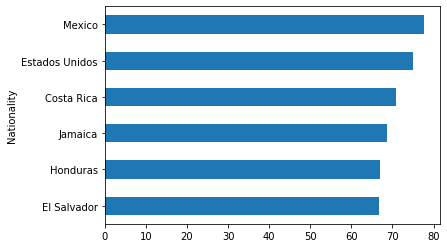

In [10]:
# Se visualiza el nivel de cada selección de acuerdo a la jerarquía de sus jugadores.

plot = potencial.sort_values( ascending=True).plot(kind='barh')

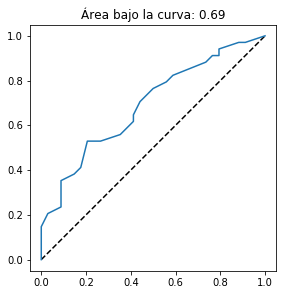

In [11]:
# Para predecir los resultados se construye un modelo de regresión lineal, cuyos predictores
# van a ser la diferencia en el ranking fifa y el nivel de los jugadores.

X, y = historico_concacaf.loc[:,['ranking_local', 'dif_ranking', 'diferencia_nivel']], historico_concacaf['gana_local']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regresion_logistica = linear_model.LogisticRegression(solver='lbfgs', C=1e-5)
features = PolynomialFeatures(degree=2)
modelo = Pipeline([('polynomial_features', features),('logistic_regression', regresion_logistica)])
modelo = modelo.fit(X_train, y_train)

fpr, tpr, _ = roc_curve(y_test, modelo.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('Área bajo la curva: {0:0.2}'.format(roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

In [12]:
# Simulación de los partidos del hexagonal.

margen_error = 0.05
hexagonal['puntos'] = 0
hexagonal['probabilidad_total'] = 0
torneo_ordenado = sorted(set(hexagonal['grupo']))

print('HEXAGONAL FINAL:')
for grupo in torneo_ordenado:
    for local, visitante in combinations(hexagonal.query('grupo == "{}"'.format(grupo)).index, 2):
        print("{} vs. {}: ".format(local, visitante), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan]]), columns=X_test.columns)
        row['ranking_local'] = hexagonal.loc[local, 'ranking FIFA']
        opp_rank = hexagonal.loc[visitante, 'ranking FIFA']
        local_pot = hexagonal.loc[local, 'Overall']
        opp_pot = hexagonal.loc[visitante, 'Overall']
        row['dif_ranking'] = row['ranking_local'] - opp_rank 
        row['diferencia_nivel'] = local_pot - opp_pot  
        local_prob_triunfo = modelo.predict_proba(row)[:,1][0]
        hexagonal.loc[local, 'probabilidad_total'] += local_prob_triunfo
        hexagonal.loc[visitante, 'probabilidad_total'] += 1-local_prob_triunfo
        puntos = 0
        if local_prob_triunfo <= 0.5 - margen_error:
            print("{} triunfa con probabilidad de {:.3f}.".format(visitante, 1-local_prob_triunfo))
            hexagonal.loc[visitante, 'puntos'] += 3
        if local_prob_triunfo > 0.5 - margen_error:
            puntos = 1
        if local_prob_triunfo >= 0.5 + margen_error:
            puntos = 3
            hexagonal.loc[local, 'puntos'] += 3
            print("{} triunfa con probabilidad de {:.3f}.".format(local, local_prob_triunfo))
        if puntos == 1:
            print("Empate.")
            hexagonal.loc[local, 'puntos'] += 1
            hexagonal.loc[visitante, 'puntos'] += 1

HEXAGONAL FINAL:
Mexico vs. Estados Unidos: Empate.
Mexico vs. Costa Rica: Mexico triunfa con probabilidad de 0.687.
Mexico vs. Jamaica: Mexico triunfa con probabilidad de 0.686.
Mexico vs. Honduras: Mexico triunfa con probabilidad de 0.816.
Mexico vs. El Salvador: Mexico triunfa con probabilidad de 0.878.
Estados Unidos vs. Costa Rica: Estados Unidos triunfa con probabilidad de 0.637.
Estados Unidos vs. Jamaica: Estados Unidos triunfa con probabilidad de 0.632.
Estados Unidos vs. Honduras: Estados Unidos triunfa con probabilidad de 0.768.
Estados Unidos vs. El Salvador: Estados Unidos triunfa con probabilidad de 0.838.
Costa Rica vs. Jamaica: Empate.
Costa Rica vs. Honduras: Costa Rica triunfa con probabilidad de 0.597.
Costa Rica vs. El Salvador: Costa Rica triunfa con probabilidad de 0.684.
Jamaica vs. Honduras: Jamaica triunfa con probabilidad de 0.612.
Jamaica vs. El Salvador: Jamaica triunfa con probabilidad de 0.699.
Honduras vs. El Salvador: Honduras triunfa con probabilidad de

In [13]:
# Visualizar a los tres que van directo al mundial y al que va a repechaje

hexagonal = hexagonal.sort_values(by=['grupo', 'puntos', 'probabilidad_total'], ascending=[True, False, False]).reset_index()
siguiente_fase = hexagonal.groupby('grupo').nth([0, 1, 2, 3]).reset_index()
siguiente_fase[['equipo', 'puntos']]

,equipo,puntos
0,Mexico,13
1,Estados Unidos,13
2,Jamaica,7
3,Costa Rica,7
